#Практический кейс
#«Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

**Задача**:
Решить задачу регрессии (одним или несколькими методами) для предсказания глубины и ширины сварного соединения, выполнив необходимые этапы (разведочный анализ, предобработка)

###Импорт библиотек

In [305]:
#импорт библиотек для работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

!pip install tabulate
!pip install catboost
%matplotlib inline

###Загрузка датасета с GitHub

In [306]:
#загрузка данных
url = 'https://raw.githubusercontent.com/Artemis-Flamme/weld_size_prediction/refs/heads/main/ebw_data.csv'
df = pd.read_csv(url)

Выполним pipeline для решения задачи регрессии:
1. EDA
2. POC
3. Modeling
4. Evaluation

#Разведочный анализ данных

##Проверка загруженной таблицы

In [307]:
#основная информация о данных
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [308]:
df.columns

Index(['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'], dtype='object')

Расшифровка:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической
системы (FP);
5. Глубина шва (Depth);
6. Ширина шва (Width).

##Изучение характеристик таблицы и её столбцов

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Можно заметить, что столбцы в наборе имеют разный числовой формат. Для удобства и корректности расчётов все столбцы нужно будет преобразвать в float64.

In [310]:
df.tail()

,IW,IF,VW,FP,Depth,Width
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76
71,45,146,9.0,60,1.32,1.76


In [311]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


##Проверка пропущенных значений

In [312]:
#проверка пропущенных значений
missing_values = df.isnull().sum()
print(missing_values)

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64


##Проверка наличия дубликатов и их количества
Поскольку у таблицы мало строк, дубликаты могут оказаться важными и не будут удаляться.

In [313]:
#обнаружение дубликатов
print("Количество дубликатов:", df.duplicated().sum())

#все дублирующиеся строки
duplicate_rows = df[df.duplicated(keep=False)]
print("Дублирующиеся строки:\n", duplicate_rows)

Количество дубликатов: 7
Дублирующиеся строки:
     IW   IF    VW  FP  Depth  Width
9   45  140   8.0  80   1.20   1.96
11  45  140   8.0  80   1.20   1.96
29  47  139   4.5  80   1.36   2.48
31  47  139   4.5  80   1.36   2.48
45  46  146  10.0  60   1.36   1.76
46  46  146  10.0  60   1.36   1.76
53  43  150   9.0  50   1.08   1.82
54  43  150   9.0  50   1.08   1.82
55  43  150   9.0  50   1.08   1.82
56  44  146   9.0  60   1.20   1.76
59  44  146   9.0  60   1.20   1.76
69  45  146   9.0  60   1.28   1.76
70  45  146   9.0  60   1.28   1.76


##Визуализация распределений

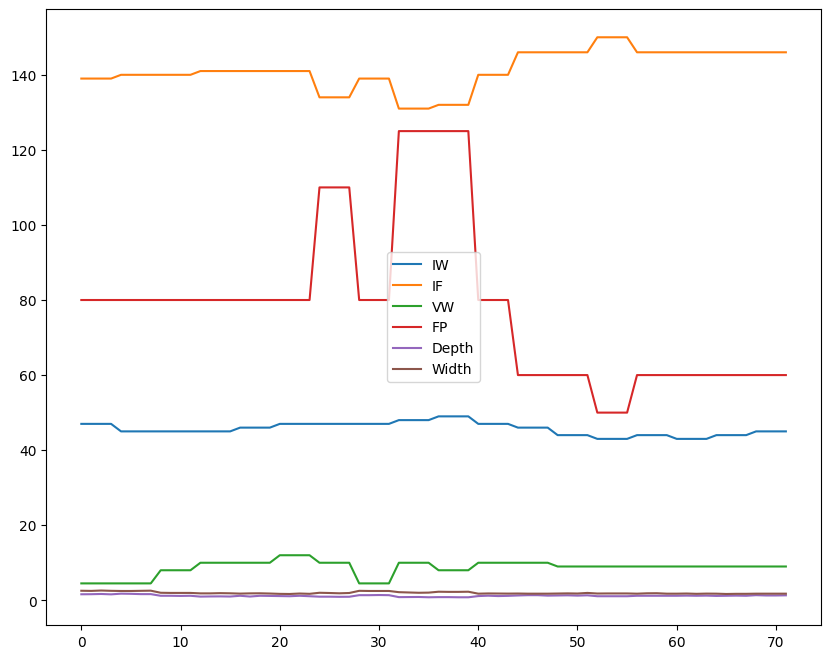

In [314]:
df.plot(figsize=(10, 8))
plt.show()

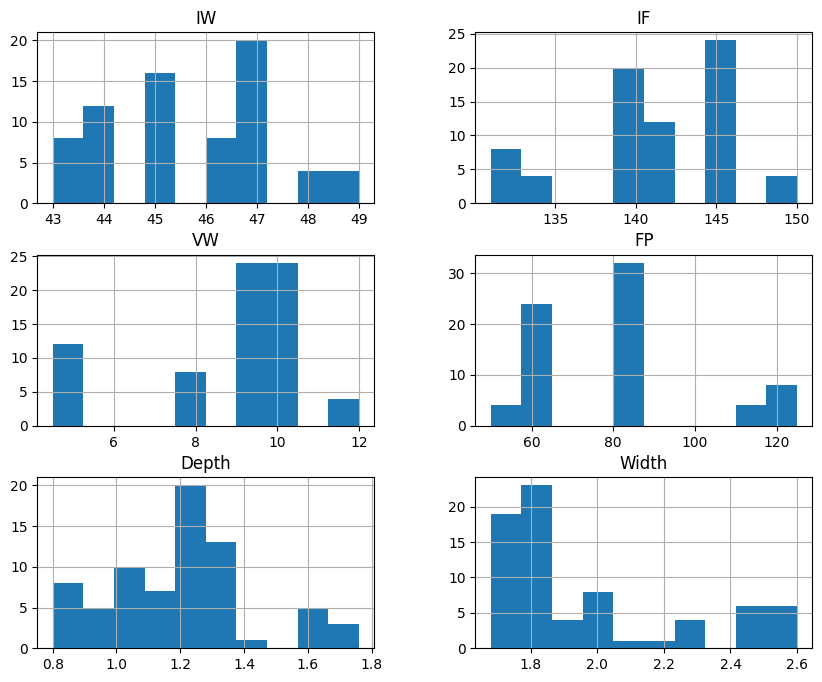

In [315]:
df.hist(figsize=(10, 8))
plt.show()

##Графики плотности

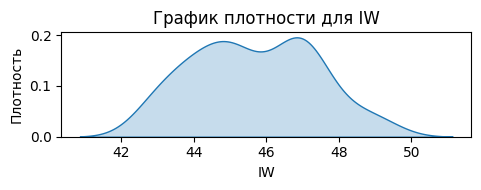

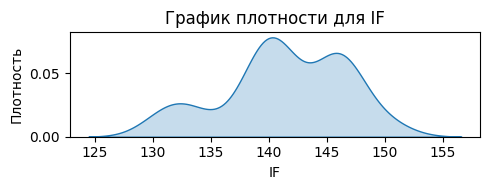

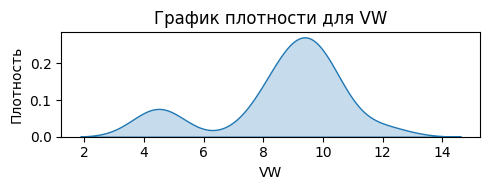

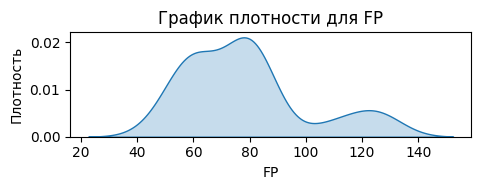

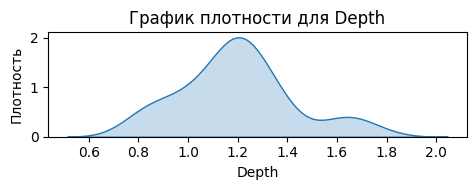

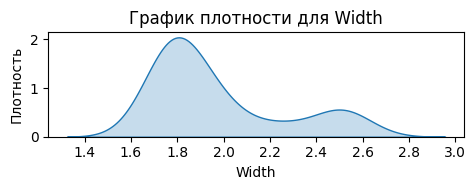

In [316]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(5, 2))
    sns.kdeplot(df[column], fill=True)
    plt.title(f'График плотности для {column}')
    plt.xlabel(column)
    plt.ylabel('Плотность')
    plt.tight_layout()
    plt.show()

##Ящик с усами

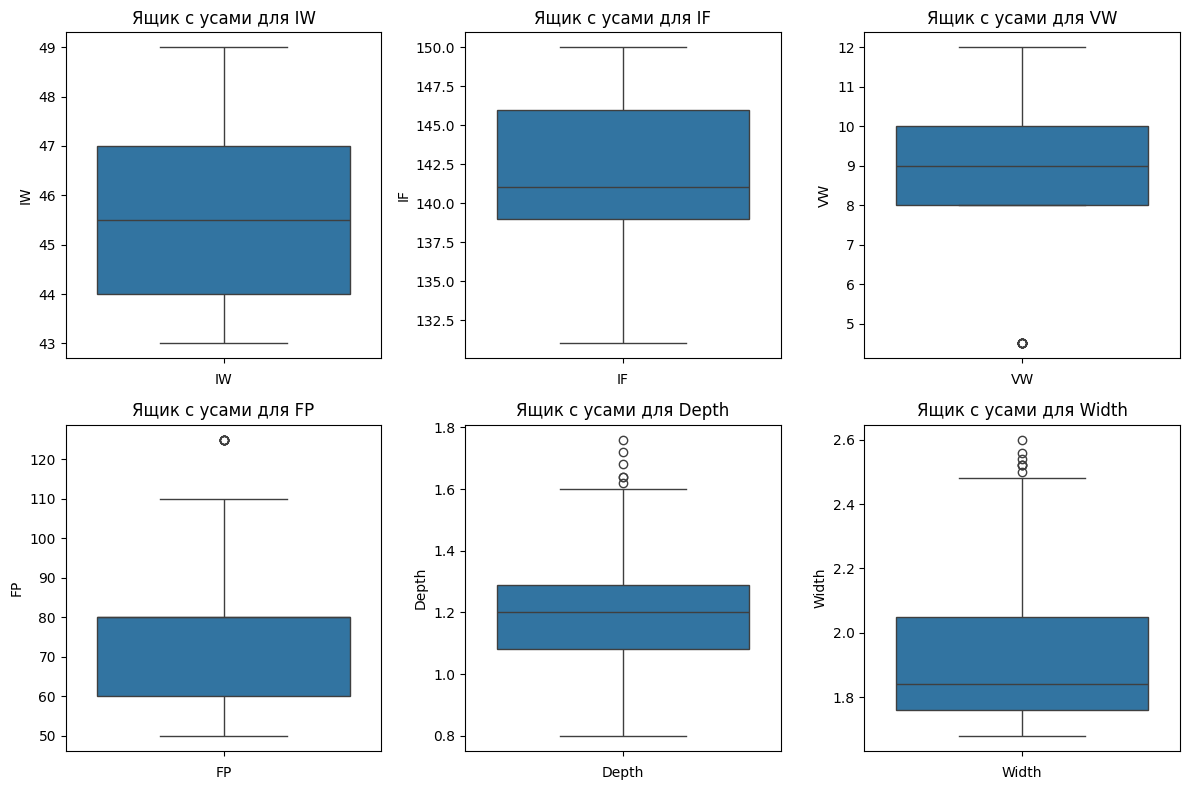

In [317]:
columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']
#Создание ящиков с усами для каждого столбца
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns):
    plt.subplot(2, 3, i + 1)  #2 строки, 3 столбца для размещения графиков
    sns.boxplot(data=df[column])
    plt.title(f'Ящик с усами для {column}')
    plt.xlabel(column)

plt.tight_layout()  #Автоматическая подстройка пространства между графиками
plt.show()  #Отображение графиков

Из ящика с усами мы можем обнаружить, что часть столбцов имеет существенные выбросы. Мы не можем определить важность этих выбросов в связи с небольшим разметром датасета, поэтому в дальнейшей работе будут использоваться модели регрессии, которые менее чувствительны к выбросам.

##Тепловая карта

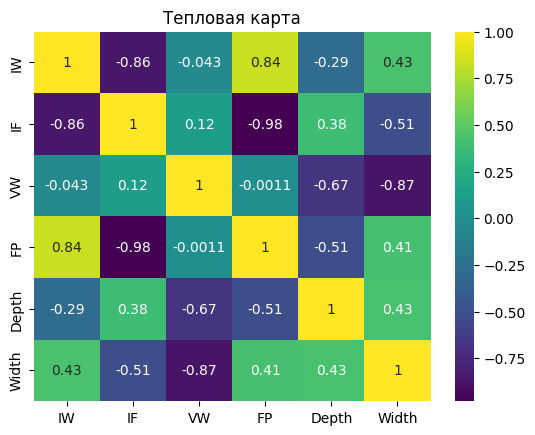

In [318]:
#Построение тепловой карты для обнаружения корреляции
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title('Тепловая карта')
plt.show()

#Предварительная обработка данных

##Преобразование всех столбцов в один формат

In [319]:
#Просмотр типов данных перед преобразованием
print("Типы данных перед преобразованием:")
print(df.dtypes)

Типы данных перед преобразованием:
IW         int64
IF         int64
VW       float64
FP         int64
Depth    float64
Width    float64
dtype: object


In [320]:
#Преобразование всех столбцов к float64
df = df.astype('float64')

In [321]:
#Просмотр типов данных после преобразования
print("\nТипы данных после преобразования:")
print(df.dtypes)


Типы данных после преобразования:
IW       float64
IF       float64
VW       float64
FP       float64
Depth    float64
Width    float64
dtype: object


##Разделение выборки на признаки и целевые переменные

In [322]:
#Определяем признаки и целевые переменные
X = df[['IW', 'IF', 'VW', 'FP']]
y_depth = df['Depth']
y_width = df['Width']

##Разделение данных на обучающую и тестовую выборки

In [323]:
from sklearn.model_selection import train_test_split, cross_val_score

In [324]:
#Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train_depth, y_test_depth = train_test_split(X, y_depth, test_size=0.2, random_state=42)
X_train, X_test, y_train_width, y_test_width = train_test_split(X, y_width, test_size=0.2, random_state=42)

##Стандартизация данных перед обучением с помощью MinMaxScaler

In [325]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [326]:
#Стандартизация
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y_depth = MinMaxScaler()
y_train_depth_scaled = scaler_y_depth.fit_transform(y_train_depth.values.reshape(-1, 1)).flatten()
y_test_depth_scaled = scaler_y_depth.transform(y_test_depth.values.reshape(-1, 1)).flatten()

scaler_y_width = MinMaxScaler()
y_train_width_scaled = scaler_y_width.fit_transform(y_train_width.values.reshape(-1, 1)).flatten()
y_test_width_scaled = scaler_y_width.transform(y_test_width.values.reshape(-1, 1)).flatten()

#Регрессионные модели

Для решения задачи регрессии были выбраны следующие модели:
1. Линейная регрессия
2. Регрессия с помощью библиотеки CatBoost
3. Случайный лес
4. Нейронная сеть

##Модель линейной регрессии

###Import

In [327]:
from sklearn.linear_model import LinearRegression

###Создание и обучение модели

In [328]:
#Создание и обучение модели регрессии с кросс-валидацией для Depth
lr_model_depth = LinearRegression()
lr_model_depth.fit(X_train_scaled, y_train_depth_scaled)
lr_cv_depth = cross_val_score(lr_model_depth, X_train_scaled, y_train_depth_scaled, cv=5, scoring='neg_mean_squared_error')

In [329]:
#Создание и обучение модели регрессии с кросс-валидацией для Width
lr_model_width = LinearRegression()
lr_model_width.fit(X_train_scaled, y_train_width_scaled)
lr_cv_width = cross_val_score(lr_model_width, X_train_scaled, y_train_width_scaled, cv=5, scoring='neg_mean_squared_error')

In [330]:
#Предсказания на тестовых данных
y_pred_depth_lr = lr_model_depth.predict(X_test_scaled)
y_pred_width_lr = lr_model_width.predict(X_test_scaled)

###Оценка моделей для Depth и Width

In [331]:
#Расчет RMSE и R2 для Depth
lr_rmse_depth = np.sqrt(mean_squared_error(y_test_depth_scaled, y_pred_depth_lr))
lr_r2_depth = r2_score(y_test_depth_scaled, y_pred_depth_lr)
lr_rmse_cv_depth = np.sqrt(-lr_cv_depth.mean())

In [332]:
#Расчет RMSE и R2 для Width
lr_rmse_width = np.sqrt(mean_squared_error(y_test_width_scaled, y_pred_width_lr))
lr_r2_width = r2_score(y_test_width_scaled, y_pred_width_lr)
lr_rmse_cv_width = np.sqrt(-lr_cv_width.mean())

In [333]:
#Оценка модели для Depth
print("\nАнализ модели для Depth:")
print(f"RMSE на тестовой выборке: {lr_rmse_depth:.4f}")
print(f"RMSE на кросс-валидации: {lr_rmse_cv_depth:.4f}")
print(f"Коэффициент детерминации: {lr_r2_depth:.4f}")
#Оценка модели для Width
print("\nАнализ модели для Width:")
print(f"RMSE на тестовой выборке: {lr_rmse_width:.4f}")
print(f"RMSE кросс-валидации: {lr_rmse_cv_width:.4f}")
print(f"Коэффициент детерминации: {lr_r2_width:.4f}")


Анализ модели для Depth:
RMSE на тестовой выборке: 0.1698
RMSE на кросс-валидации: 0.1020
Коэффициент детерминации: 0.6154

Анализ модели для Width:
RMSE на тестовой выборке: 0.0521
RMSE кросс-валидации: 0.0827
Коэффициент детерминации: 0.9771


###Вывод графиков

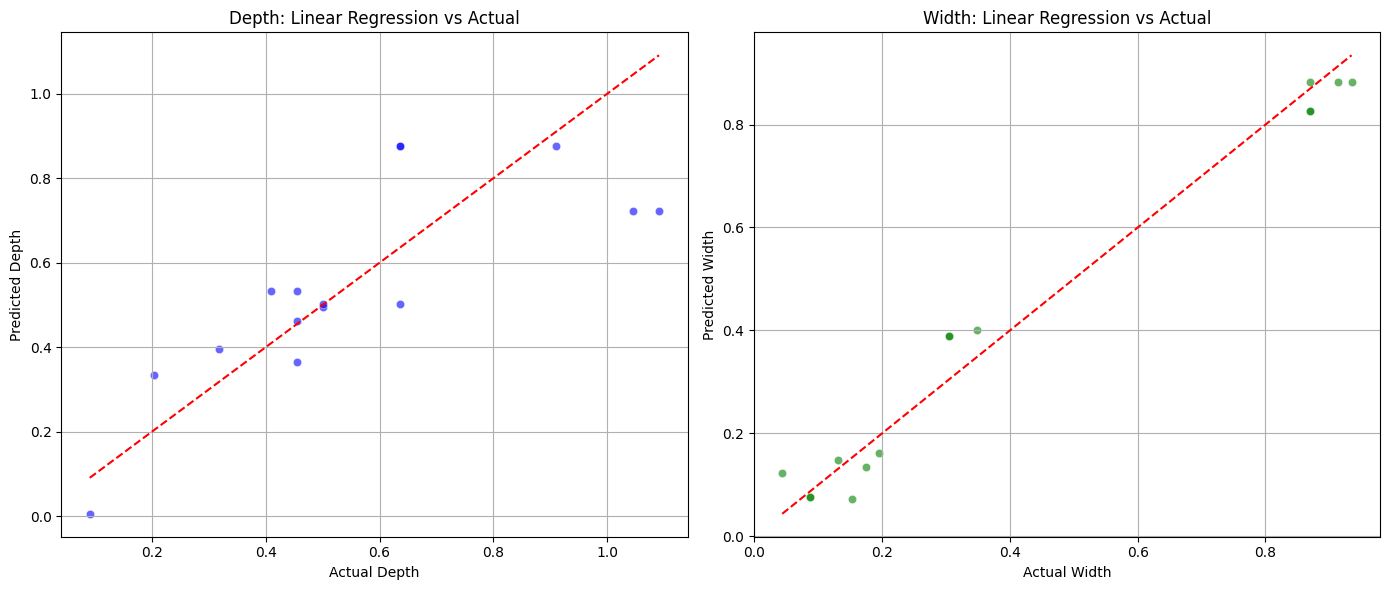

In [334]:
# Визуализация
plt.figure(figsize=(14, 6))

#Depth
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_depth_scaled, y=y_pred_depth_lr, alpha=0.6, color='blue')
plt.plot([y_test_depth_scaled.min(), y_test_depth_scaled.max()], [y_test_depth_scaled.min(), y_test_depth_scaled.max()], 'r--')
plt.title('Depth: Linear Regression vs Actual')
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.grid()

# Width
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_width_scaled, y=y_pred_width_lr, alpha=0.6, color='green')
plt.plot([y_test_width_scaled.min(), y_test_width_scaled.max()], [y_test_width_scaled.min(), y_test_width_scaled.max()], 'r--')
plt.title('Width: Linear Regression vs Actual')
plt.xlabel('Actual Width')
plt.ylabel('Predicted Width')
plt.grid()

plt.tight_layout()
plt.show()

##Регрессия с помощью библиотеки CatBoost

###Import

In [335]:
import catboost
from catboost import CatBoostRegressor

###Создание и обучение модели

In [336]:
#Создаем и обучаем модель CatBoost регрессии для Depth
cb_model_depth = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
cb_model_depth.fit(X_train_scaled, y_train_depth_scaled)

In [337]:
#Кросс-валидация Depth
cb_cv_depth = cross_val_score(cb_model_depth, X_train_scaled, y_train_depth_scaled, cv=5, scoring='neg_mean_squared_error')

In [338]:
#Прогнозируем Depth
y_pred_depth = cb_model_depth.predict(X_test_scaled)

In [339]:
# Создаем и обучаем модель CatBoost регрессии для Width
cb_model_width = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)
cb_model_width.fit(X_train_scaled, y_train_width_scaled)

In [340]:
#Кросс-валидация Width
cb_cv_width = cross_val_score(cb_model_width, X_train_scaled, y_train_width_scaled, cv=5, scoring='neg_mean_squared_error')

In [341]:
#Прогнозируем Width
y_pred_width = cb_model_width.predict(X_test_scaled)

###Оценка моделей для Depth и Width

In [342]:
#Расчет RMSE и R2 для Depth
cb_rmse_depth = np.sqrt(mean_squared_error(y_test_depth_scaled, y_pred_depth))
cb_r2_depth = r2_score(y_test_depth_scaled, y_pred_depth)
cb_rmse_cv_depth = np.sqrt(-cb_cv_depth.mean())

In [343]:
#Расчет RMSE и R2 для Width
cb_rmse_width = np.sqrt(mean_squared_error(y_test_width_scaled, y_pred_width))
cb_r2_width = r2_score(y_test_width_scaled, y_pred_width)
cb_rmse_cv_width = np.sqrt(-cb_cv_width.mean())

In [344]:
#Оценка модели для Depth
print("\nАнализ модели для Depth:")
print(f"RMSE на тестовой выборке: {cb_rmse_depth:.4f}")
print(f"RMSE на кросс-валидации: {cb_rmse_cv_depth:.4f}")
print(f"Коэффициент детерминации: {cb_r2_depth:.4f}")
#Оценка модели для Width
print("\nАнализ модели для Width:")
print(f"RMSE на тестовой выборке: {cb_rmse_width:.4f}")
print(f"RMSE кросс-валидации: {cb_rmse_cv_width:.4f}")
print(f"Коэффициент детерминации: {cb_r2_width:.4f}")


Анализ модели для Depth:
RMSE на тестовой выборке: 0.0942
RMSE на кросс-валидации: 0.0880
Коэффициент детерминации: 0.8817

Анализ модели для Width:
RMSE на тестовой выборке: 0.0458
RMSE кросс-валидации: 0.0644
Коэффициент детерминации: 0.9823


###Вывод графиков

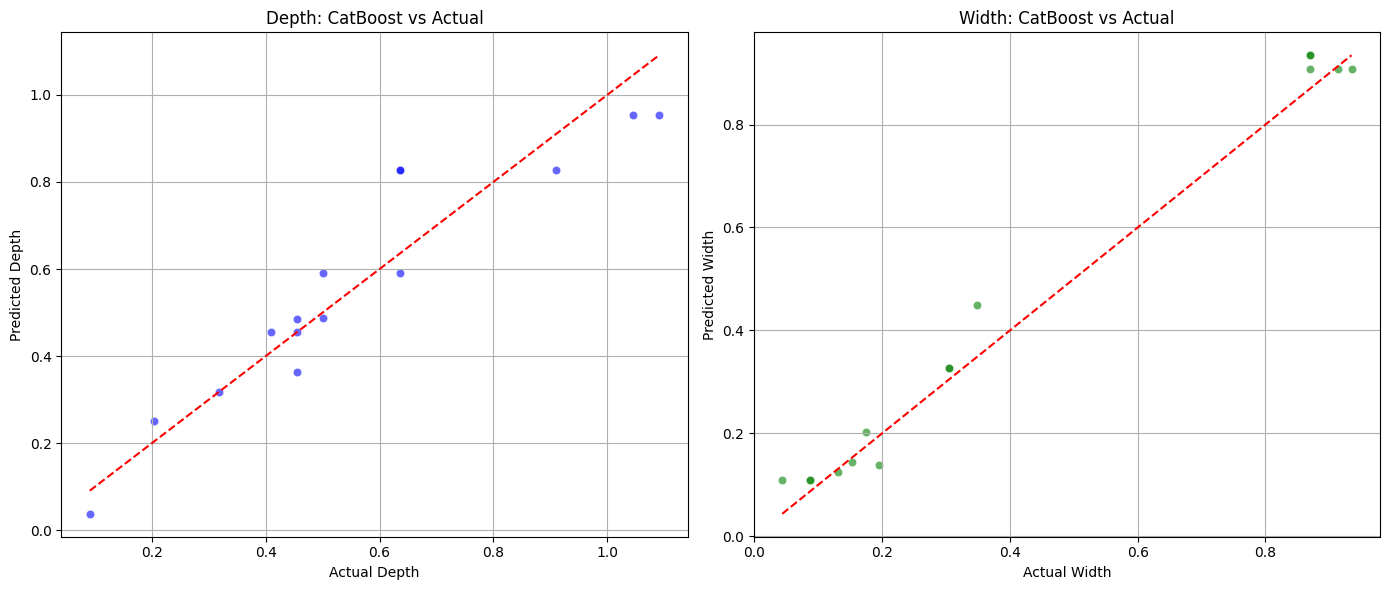

In [345]:
#Визуализация
plt.figure(figsize=(14, 6))

#Depth
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_depth_scaled, y=y_pred_depth, alpha=0.6, color='blue')
plt.plot([y_test_depth_scaled.min(), y_test_depth_scaled.max()],
         [y_test_depth_scaled.min(), y_test_depth_scaled.max()], 'r--')
plt.title('Depth: CatBoost vs Actual')
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.grid()

#Width
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_width_scaled, y=y_pred_width, alpha=0.6, color='green')
plt.plot([y_test_width_scaled.min(), y_test_width_scaled.max()],
         [y_test_width_scaled.min(), y_test_width_scaled.max()], 'r--')
plt.title('Width: CatBoost vs Actual')
plt.xlabel('Actual Width')
plt.ylabel('Predicted Width')
plt.grid()

plt.tight_layout()
plt.show()

##Метод случайного леса

###Import

In [346]:
from sklearn.ensemble import RandomForestRegressor

###Создание и обучение модели

In [347]:
#Создаем и обучаем модель случайного леса для Depth
rf_model_depth = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_depth.fit(X_train_scaled, y_train_depth_scaled)

RandomForestRegressor(random_state=42)

In [348]:
#Кросс-валидация Depth
rf_cv_depth = cross_val_score(rf_model_depth, X_train_scaled, y_train_depth_scaled, cv=5, scoring='neg_mean_squared_error')

In [349]:
#Прогнозируем Depth
y_pred_depth_rf = rf_model_depth.predict(X_test_scaled)

In [350]:
#Создаем и обучаем модель случайного леса для Width
rf_model_width = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_width.fit(X_train_scaled, y_train_width_scaled)

RandomForestRegressor(random_state=42)

In [351]:
#Кросс-валидация Width
rf_cv_width = cross_val_score(rf_model_width, X_train_scaled, y_train_width_scaled, cv=5, scoring='neg_mean_squared_error')

In [352]:
#Прогнозируем Width
y_pred_width_rf = rf_model_width.predict(X_test_scaled)

###Оценка моделей для Depth и Width

In [353]:
#Расчет RMSE и R2 для Depth
rf_rmse_depth = np.sqrt(mean_squared_error(y_test_depth_scaled, y_pred_depth_rf))
rf_r2_depth = r2_score(y_test_depth_scaled, y_pred_depth_rf)
rf_rmse_cv_depth = np.sqrt(-rf_cv_depth.mean())

In [354]:
#Расчет RMSE и R2 для Width
rf_rmse_width = np.sqrt(mean_squared_error(y_test_width_scaled, y_pred_width_rf))
rf_r2_width = r2_score(y_test_width_scaled, y_pred_width_rf)
rf_rmse_cv_width = np.sqrt(-rf_cv_width.mean())

In [355]:
#Оценка модели для Depth
print("\nАнализ модели для Depth:")
print(f"RMSE на тестовой выборке: {rf_rmse_depth:.4f}")
print(f"RMSE на кросс-валидации: {rf_rmse_cv_depth:.4f}")
print(f"Коэффициент детерминации: {rf_r2_depth:.4f}")

#Оценка модели для Width
print("\nАнализ модели для Width:")
print(f"RMSE на тестовой выборке: {rf_rmse_width:.4f}")
print(f"RMSE кросс-валидации: {rf_rmse_cv_width:.4f}")
print(f"Коэффициент детерминации: {rf_r2_width:.4f}")


Анализ модели для Depth:
RMSE на тестовой выборке: 0.1006
RMSE на кросс-валидации: 0.0850
Коэффициент детерминации: 0.8650

Анализ модели для Width:
RMSE на тестовой выборке: 0.0503
RMSE кросс-валидации: 0.0693
Коэффициент детерминации: 0.9787


###Вывод графиков

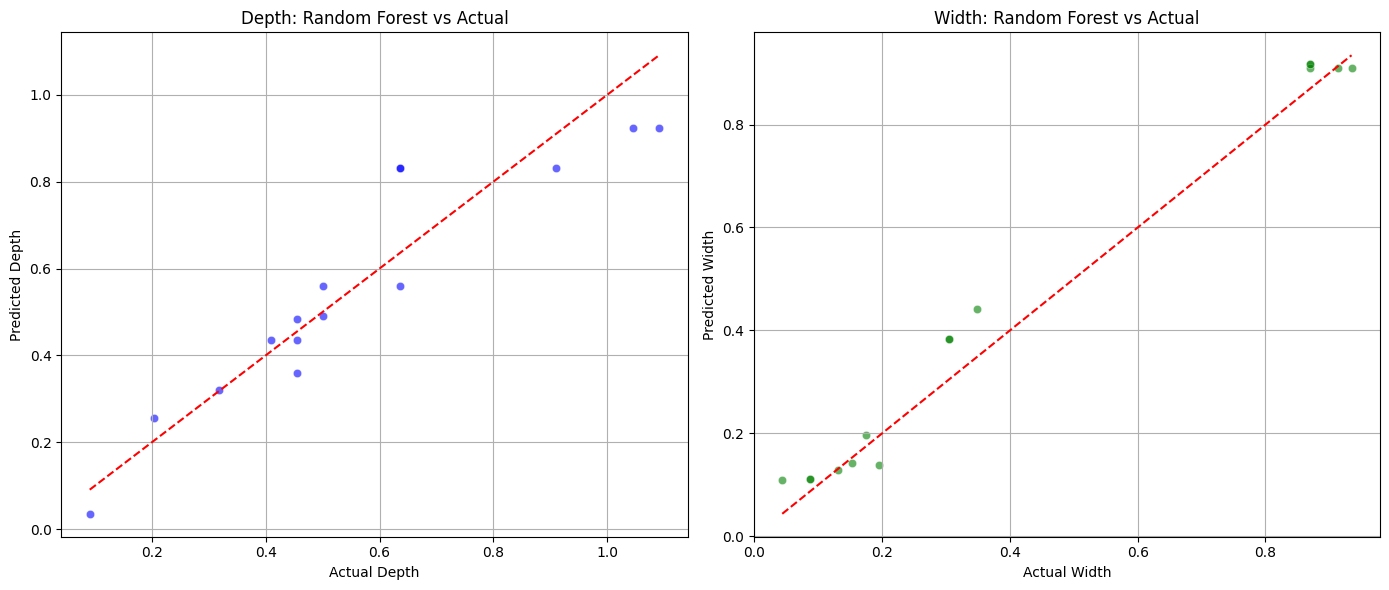

In [356]:
#Визуализация
plt.figure(figsize=(14, 6))

#Depth
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_depth_scaled, y=y_pred_depth_rf, alpha=0.6, color='blue')
plt.plot([y_test_depth_scaled.min(), y_test_depth_scaled.max()],
         [y_test_depth_scaled.min(), y_test_depth_scaled.max()], 'r--')
plt.title('Depth: Random Forest vs Actual')
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.grid()

#Width
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_width_scaled, y=y_pred_width_rf, alpha=0.6, color='green')
plt.plot([y_test_width_scaled.min(), y_test_width_scaled.max()],
         [y_test_width_scaled.min(), y_test_width_scaled.max()], 'r--')
plt.title('Width: Random Forest vs Actual')
plt.xlabel('Actual Width')
plt.ylabel('Predicted Width')
plt.grid()

plt.tight_layout()
plt.show()

##Нейронная сеть

###Стандартизация данных перед обучением с помощью RobustScaler

Нейронная сеть при работе со стандартизированными через MinMaxScaler данными показывала либо очень низкие, либо аномальные результаты. Для стабилизации работы данные были стабилизированы через метод RobustScaler, который также подходит для работы с датасетами с выбросами.

In [357]:
from sklearn.preprocessing import RobustScaler

In [358]:
# Стандартизация данных с помощью RobustScaler
scaler_rs_X = RobustScaler()
X_train_scaled_rs = scaler_rs_X.fit_transform(X_train)
X_test_scaled_rs = scaler_rs_X.transform(X_test)

# Стандартизация целевых переменных
scaler_y_depth_rs = RobustScaler()
y_train_depth_scaled_rs = scaler_y_depth_rs.fit_transform(y_train_depth.values.reshape(-1, 1))
y_test_depth_scaled_rs = scaler_y_depth_rs.transform(y_test_depth.values.reshape(-1, 1))

scaler_y_width_rs = RobustScaler()
y_train_width_scaled_rs = scaler_y_width_rs.fit_transform(y_train_width.values.reshape(-1, 1))
y_test_width_scaled_rs = scaler_y_width_rs.transform(y_test_width.values.reshape(-1, 1))

###Import

In [359]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

###Создание модели

In [360]:
#Создание и компиляция модели
def create_model():
    """

    Returns:

    """
    model = Sequential()
    model.add(Input(shape=(X_train_scaled_rs.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2))  #2 выхода для Depth и Width

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

###Обучение модели

In [361]:
#Обучение модели
model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled_rs,
                    np.column_stack((y_train_depth_scaled_rs, y_train_width_scaled_rs)),
                    epochs=200,
                    batch_size=16,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - loss: 1.2011 - val_loss: 1.4325
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.9094 - val_loss: 1.1717
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.9166 - val_loss: 0.9737
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6387 - val_loss: 0.8008
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4112 - val_loss: 0.6691
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.5934 - val_loss: 0.5420
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4465 - val_loss: 0.4295
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3082 - val_loss: 0.3428
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2441 - val_loss: 0.2757
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2378 - val_loss: 0.2384
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2015 - val_loss: 0.2190
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1787 - val_l

In [362]:
#Прогнозирование
y_pred_scaled_nn = model.predict(X_test_scaled_rs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [363]:
#Обратное преобразование для предсказаний
y_pred_depth_nn = scaler_y_depth_rs.inverse_transform(y_pred_scaled_nn[:, 0].reshape(-1, 1))
y_pred_width_nn = scaler_y_width_rs.inverse_transform(y_pred_scaled_nn[:, 1].reshape(-1, 1))

###Оценка моделей для Depth и Width

In [364]:
#Расчет RMSE и R2 для Depth
nn_rmse_depth = np.sqrt(mean_squared_error(y_test_depth, y_pred_depth_nn))
nn_r2_depth = r2_score(y_test_depth, y_pred_depth_nn)

In [365]:
#Расчет RMSE и R2 для Width
nn_rmse_width = np.sqrt(mean_squared_error(y_test_width, y_pred_width_nn))
nn_r2_width = r2_score(y_test_width, y_pred_width_nn)

In [366]:
#Оценка модели для Depth
print("\nАнализ модели для Depth:")
print(f"RMSE на тестовой выборке: {nn_rmse_depth:.4f}")
print(f"Коэффициент детерминации: {nn_r2_depth:.4f}\n")
#Оценка модели для Width
print("Анализ модели для Width:")
print(f"RMSE на тестовой выборке: {nn_rmse_width:.4f}")
print(f"Коэффициент детерминации: {nn_r2_width:.4f}\n")


Анализ модели для Depth:
RMSE на тестовой выборке: 0.1185
Коэффициент детерминации: 0.7584

Анализ модели для Width:
RMSE на тестовой выборке: 0.0314
Коэффициент детерминации: 0.9902



###Вывод графиков

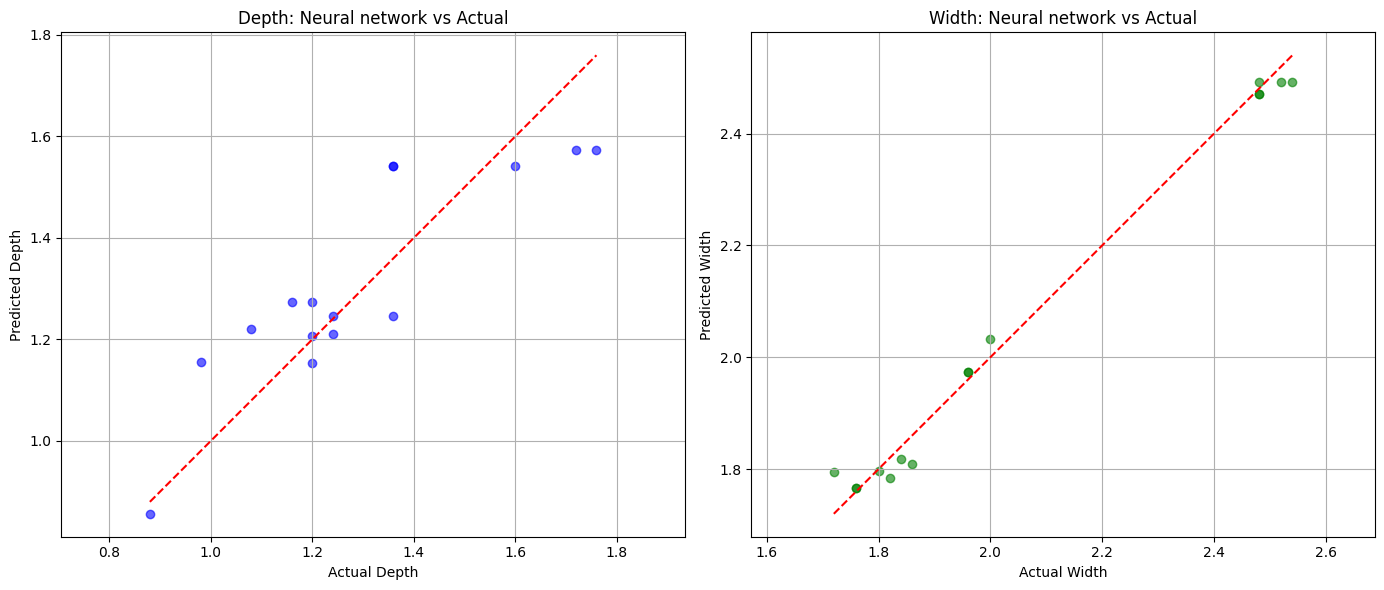

In [367]:
#Визуализация результатов
plt.figure(figsize=(14, 6))

# Для Depth
plt.subplot(1, 2, 1)
new_var = plt.scatter
new_var(y_test_depth, y_pred_depth_nn, alpha=0.6, color='blue')
plt.plot([y_test_depth.min(), y_test_depth.max()], [y_test_depth.min(), y_test_depth.max()], 'r--')
plt.title('Depth: Neural network vs Actual')
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.axis('equal')
plt.grid()

# Для Width
plt.subplot(1, 2, 2)
plt.scatter(y_test_width, y_pred_width_nn, alpha=0.6, color='green')
plt.plot([y_test_width.min(), y_test_width.max()], [y_test_width.min(), y_test_width.max()], 'r--')
plt.title('Width: Neural network vs Actual')
plt.xlabel('Actual Width')
plt.ylabel('Predicted Width')
plt.axis('equal')
plt.grid()

plt.tight_layout()
plt.show()

#Сравнение результатов

##Import

In [368]:
from tabulate import tabulate

##Создание датафрейма для анализа значений метрик использованных моделей

In [369]:
data = {
    'Модель': ['Линейная регрессия', 'CatBoost', 'Случайный лес', 'Нейронная сеть'],
    'RMSE (Depth)': [lr_rmse_depth, cb_rmse_depth, rf_rmse_depth, nn_rmse_depth],
    'R2 (Depth)': [lr_r2_depth, cb_r2_depth, rf_r2_depth, nn_r2_depth],
    'RMSE CV (Depth)': [lr_rmse_cv_depth, cb_rmse_cv_depth, rf_rmse_cv_depth, None],
    'RMSE (Width)': [lr_rmse_width, cb_rmse_width, rf_rmse_width, nn_rmse_width],
    'R2 (Width)': [lr_r2_width, cb_r2_width, rf_r2_width, nn_r2_width],
    'RMSE CV (Width)': [lr_rmse_cv_width, cb_rmse_cv_width, rf_rmse_cv_width, None],
}

In [370]:
# Создание DataFrame
results_df = pd.DataFrame(data)

In [371]:
#Установка отображения с фиксированной шириной
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [372]:
# Округление значений до 4 знаков после запятой
results_df[['RMSE (Depth)', 'R2 (Depth)', 'RMSE CV (Depth)',
            'RMSE (Width)', 'R2 (Width)', 'RMSE CV (Width)']] = results_df[
    ['RMSE (Depth)', 'R2 (Depth)', 'RMSE CV (Depth)',
     'RMSE (Width)', 'R2 (Width)', 'RMSE CV (Width)']].round(4)

In [373]:
# Вывод таблицы
print(results_df)

               Модель  RMSE (Depth)  R2 (Depth)  RMSE CV (Depth)  RMSE (Width)  R2 (Width)  RMSE CV (Width)
0  Линейная регрессия        0.1698      0.6154            0.102        0.0521      0.9771           0.0827
1            CatBoost        0.0942      0.8817            0.088        0.0458      0.9823           0.0644
2       Случайный лес        0.1006      0.8650            0.085        0.0503      0.9787           0.0693
3      Нейронная сеть        0.1185      0.7584              NaN        0.0314      0.9902              NaN


##Сортировка и определение лучшей модели по показателям

In [374]:
#Сортировка по RMSE и R² для Depth
sorted_rmse_depth = results_df[['Модель', 'RMSE (Depth)']].sort_values(by='RMSE (Depth)')
sorted_r2_depth = results_df[['Модель', 'R2 (Depth)']].sort_values(by='R2 (Depth)', ascending=False)

In [375]:
#Объединение отсортированных значений для Depth
final_sorted_df_depth = sorted_rmse_depth.merge(sorted_r2_depth, on='Модель', suffixes=('_RMSE', '_R2'))

In [376]:
#Сортировка по RMSE и R² для Width
sorted_rmse_width = results_df[['Модель', 'RMSE (Width)']].sort_values(by='RMSE (Width)')
sorted_r2_width = results_df[['Модель', 'R2 (Width)']].sort_values(by='R2 (Width)', ascending=False)

In [377]:
#Объединение отсортированных значений для Width
final_sorted_df_width = sorted_rmse_width.merge(sorted_r2_width, on='Модель', suffixes=('_RMSE', '_R2'))

In [378]:
#Вывод таблицы результатов для Depth
print("Таблица результатов для Depth:")
print(tabulate(final_sorted_df_depth, headers='keys', tablefmt='psql', showindex=False))
best_model_rmse_depth = final_sorted_df_depth.iloc[0]['Модель']
best_model_r2_depth = final_sorted_df_depth.sort_values(by='R2 (Depth)', ascending=False).iloc[0]['Модель']
print(f"\nЛучшая модель по RMSE для Depth: {best_model_rmse_depth}")
print(f"Лучшая модель по R² для Depth: {best_model_r2_depth}\n")

Таблица результатов для Depth:
+--------------------+----------------+--------------+
| Модель             |   RMSE (Depth) |   R2 (Depth) |
|--------------------+----------------+--------------|
| CatBoost           |         0.0942 |       0.8817 |
| Случайный лес      |         0.1006 |       0.865  |
| Нейронная сеть     |         0.1185 |       0.7584 |
| Линейная регрессия |         0.1698 |       0.6154 |
+--------------------+----------------+--------------+

Лучшая модель по RMSE для Depth: CatBoost
Лучшая модель по R² для Depth: CatBoost



In [379]:
#Вывод таблицы результатов для Width
print("Таблица результатов для Width:")
print(tabulate(final_sorted_df_width, headers='keys', tablefmt='psql', showindex=False))
best_model_rmse_width = final_sorted_df_width.iloc[0]['Модель']
best_model_r2_width = final_sorted_df_width.sort_values(by='R2 (Width)', ascending=False).iloc[0]['Модель']
print(f"\nЛучшая модель по RMSE для Width: {best_model_rmse_width}")
print(f"Лучшая модель по R² для Width: {best_model_r2_width}\n")

Таблица результатов для Width:
+--------------------+----------------+--------------+
| Модель             |   RMSE (Width) |   R2 (Width) |
|--------------------+----------------+--------------|
| Нейронная сеть     |         0.0314 |       0.9902 |
| CatBoost           |         0.0458 |       0.9823 |
| Случайный лес      |         0.0503 |       0.9787 |
| Линейная регрессия |         0.0521 |       0.9771 |
+--------------------+----------------+--------------+

Лучшая модель по RMSE для Width: Нейронная сеть
Лучшая модель по R² для Width: Нейронная сеть



##Визуализация в виде графиков

In [380]:
#Преобразование в формат для Seaborn
df_melted_rmse = results_df.melt(id_vars='Модель', value_vars=['RMSE (Depth)', 'RMSE (Width)'], var_name='Тип', value_name='RMSE')
df_melted_r2 = results_df.melt(id_vars='Модель', value_vars=['R2 (Depth)', 'R2 (Width)'], var_name='Тип', value_name='R2')

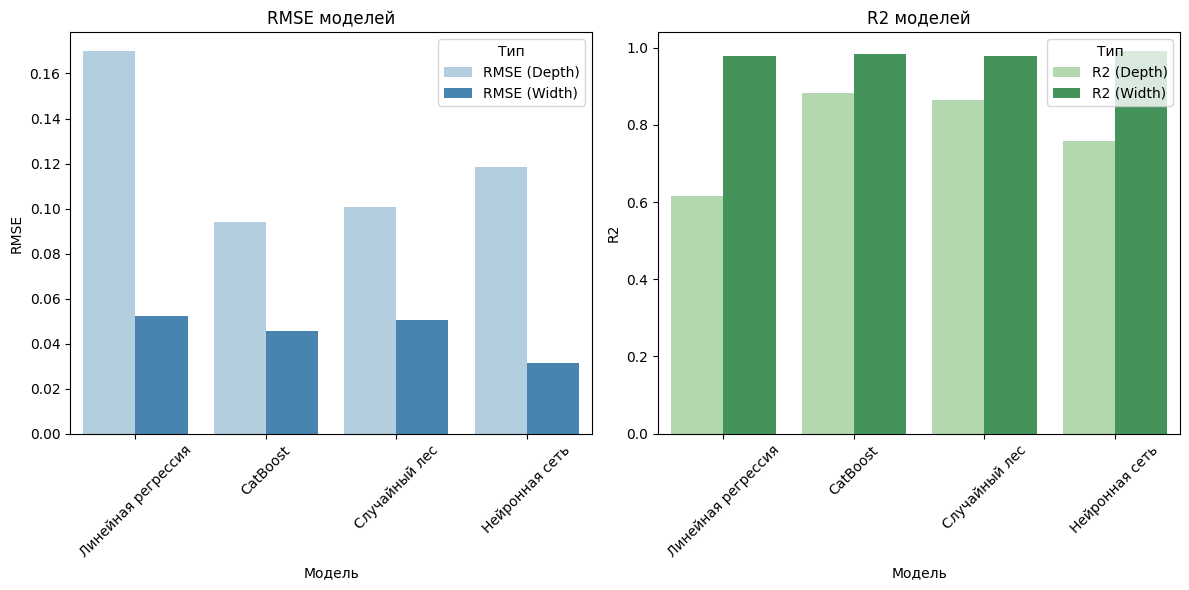

In [381]:
#Визуализация результатов
plt.figure(figsize=(12, 6))

#График RMSE
plt.subplot(1, 2, 1)
sns.barplot(data=df_melted_rmse, x='Модель', y='RMSE', hue='Тип', palette='Blues')
plt.title('RMSE моделей')
plt.xticks(rotation=45)

#График R2
plt.subplot(1, 2, 2)
sns.barplot(data=df_melted_r2, x='Модель', y='R2', hue='Тип', palette='Greens')
plt.title('R2 моделей')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#Выводы

Для решения задачи регрессии для предсказания предсказания глубины и ширины сварного соединения были использованы следующие модели:
1. Линейная регрессия
2. Регрессия с помощью библиотеки CatBoost
3. Случайный лес
4. Нейронная сеть

Для каждой модели были вычислены значения метрик RMSE и R², составлена таблица значений и отсортирована. Для первых трёх моделей была проведена кросс-валидация и вычислено также RMSE для неё. В результате сопоставления результатов было выявлено следующее:
* Лучшей моделью для выявления значений глубины является регрессия CatBoot.
* Лучшей моделью для выявления значений ширины является нейронная сеть. Однако нейронная сеть при переобучении иногда выдавала метрики, говорящие о более низком качестве, следующей моделью по качеству метрик является также регрессия CatBoot.
* Метод случайного леса показывает хороший стабильный результат для обоих искомых параметров.
* Линейная регрессия показывает средние результаты.

Для улучшения качества работ моделей можно:
* использование комбинаций моделей (например, методы бэггинга и бустинга);
* эксперименты с гиперпараметрами моделей для повышения их производительности;
* расширение датасета дополнительными реальными или синтетическими значениями.